# Evaluate cross-validation results

This notebook analyzes the results of the cross-validation sweep over model rank parameters to identify the most parismonious model using held-out log likelihood.

This notebook consists of the following sections:
- Held-out log likelihood vs. rank
- Model similarity analysis vs. rank
    - I hypothesize that models that are "underfit" have far greater stability, models that "overfit" have less stability
    - Similar to fitting LDA, model likely needs slightly more degrees of freedom (rank) than actually necessary, but those extra dofs can be removed after the fact.


In [60]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from tqdm.auto import tqdm
import itertools
import numpy as onp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from dtd.utils import (
    create_block_speckled_mask,
    download_wnb_params,
    get_wnb_project_df
)
from dtd.viz import plot_buffered_mask

## Visualize block speckled mask

In [65]:
rng = onp.random.default_rng(seed=0)

frac_mask = 0.20
block_shape = (1,3)
buffer_size = (0,1)
frac_include_buffer = False

# Construct masks 
holdout_mask, buffer_mask = create_block_speckled_mask(
    rng,
    (500, 20),
    block_shape=block_shape,
    buffer_size=buffer_size,
    frac_mask=frac_mask,
    frac_include_buffer=False,
)  # shape (n_train, n_timebins)


(<Figure size 1600x400 with 11 Axes>,
 array([<Axes: title={'center': '0-50'}>,
        <Axes: title={'center': '50-100'}>,
        <Axes: title={'center': '100-150'}>,
        <Axes: title={'center': '150-200'}>,
        <Axes: title={'center': '200-250'}>,
        <Axes: title={'center': '250-300'}>,
        <Axes: title={'center': '300-350'}>,
        <Axes: title={'center': '350-400'}>,
        <Axes: title={'center': '400-450'}>,
        <Axes: title={'center': '450-500'}>, <Axes: >], dtype=object))

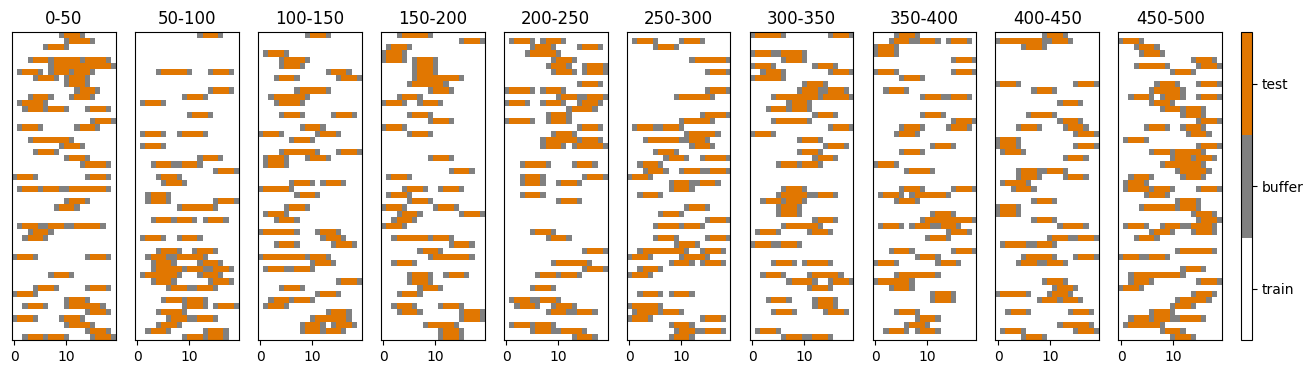

In [69]:
plot_buffered_mask(holdout_mask, buffer_mask, max_sessions_per_col=50, fig=plt.figure(figsize=(16,4)))

## Evaluate held-out log-likelihood vs. ranks

In [2]:
# Project is specified by <entity/project-name>
wnb_entity = 'eyz'
wnb_project = 'moseq-dtd-sweep-20250130-speckle-only'

config_keys = ['k1', 'k2', 'k3']
summary_keys = ['avg_test_ll']

df = get_wnb_project_df(wnb_entity, wnb_project, config_keys, summary_keys)
df

,id,name,k1,k2,k3,avg_test_ll
0,bf89l2xg,bumbling-resonance-1,5,2,5,-23.701851
1,0kfwvagh,solar-blaze-2,5,2,10,-21.986660
2,xs886dzg,dazzling-sun-3,5,2,20,-22.284842
3,eourunsv,chocolate-field-4,5,2,30,-22.287405
4,9kqfrnxl,fresh-sponge-5,5,2,40,-21.978079
...,...,...,...,...,...,...
445,5dnxoc92,happy-smoke-446,40,8,10,-19.676674
446,ti8d88h7,desert-frog-447,40,8,20,-18.455303
447,rvpcremu,fancy-haze-448,40,8,30,-17.693424
448,pn0s5fyv,azure-gorge-449,40,8,40,-18.247656


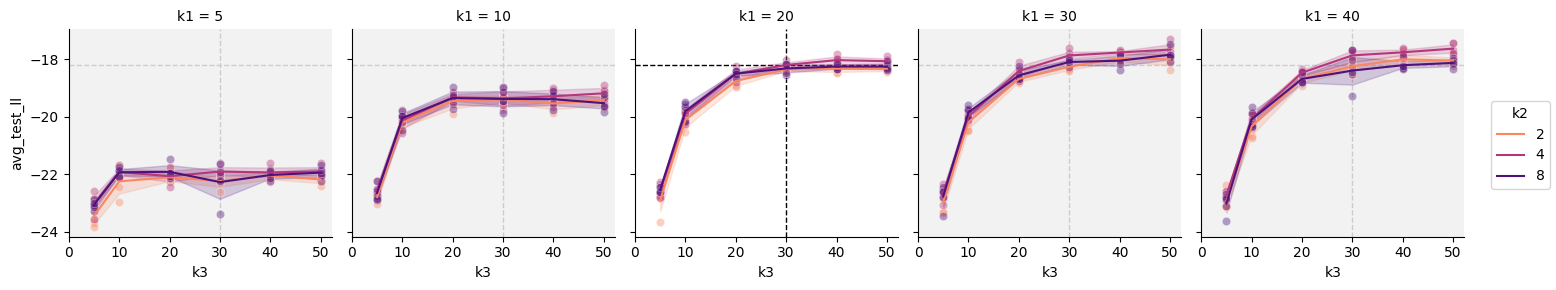

In [58]:
# based on inspection, we choose the following rank
selected_rank = dict(
    k1 = 20, k2 = 4, k3 = 30,
)

# Mean ll of selection (group by and agg are difficult to work with)
mask = (df[col_var] == selected_rank[col_var]) & (df[hue_var] == selected_rank[hue_var]) & (df[x_var] == selected_rank[x_var])
selected_ll_mean = df[mask]['avg_test_ll'].mean()

# Index of selected column
i_col = (onp.argwhere(df[col_var].unique() == selected_rank[col_var])).item()

# ----------------------------------------------------------------------------
col_var, hue_var, x_var = "k1", "k2", "k3"
# col_var, hue_var, x_var = "k2", "k1", "k3"
# col_var, hue_var, x_var = "k2", "k3", "k1"
g = sns.FacetGrid(df, col=col_var, hue=hue_var, palette="magma_r")
g.map(sns.lineplot, x_var, "avg_test_ll")
g.add_legend(frameon=True)
g.map(sns.scatterplot, x_var, "avg_test_ll", markers='.', alpha=0.4)

for i, ax in enumerate(g.axes.ravel()):
    ax.set_xlim(left=0)

    c = 'k' if i == i_col else '0.8' 
    ax.axvline(selected_rank[x_var], c=c, ls='--', lw=1, zorder=0)
    ax.axhline(selected_ll_mean, c=c, ls='--', lw=1, zorder=0)

    if i != i_col:
        ax.set_facecolor('0.95')


plt.show()